# 0.0 Imports

In [1]:
import pandas as pd
#import inflection 
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
#import random
#import pickle
#import xgboost as xgb
    
#from boruta import BorutaPy    
from scipy import stats
from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Functions

In [67]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2cor = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcor = k - (k-1)**2/(n-1)
    rcor = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2cor/n) / (min(kcor-1,rcor-1)))

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes', 'f', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('data/data.csv', low_memory=False)

In [4]:
df_raw.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


# 1.0 Data description

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## 1.1  Rename Columns

In [7]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']
#snakecase = lambda x: inflection.underscore( x )
#cols_new = list(map(snakecase, cols_old))
cols_new = ['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud']

# rename
df1.columns = cols_new

df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.2  Data Dimensions

In [8]:
print('Number of Rows: {}'. format(df1.shape[0]))
print('Number of Columns: {}'. format(df1.shape[1]))

Number of Rows: 6362620
Number of Columns: 11


## 1.3 Data types

In [9]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.5 Change Types

In [11]:
df1[['is_fraud','is_flagged_fraud']] = df1[['is_fraud','is_flagged_fraud']].astype(object)
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud             object
is_flagged_fraud     object
dtype: object

## 1.6 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### 1.6.1 Numerical Attributes

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,7.430000e+02,7.420000e+02,2.433972e+02,239.000,1.423320e+02,0.375177,0.329071
1,amount,0.0,9.244552e+07,9.244552e+07,1.798619e+05,74871.940,6.038582e+05,30.993949,1797.956705
2,oldbalance_org,0.0,5.958504e+07,5.958504e+07,8.338831e+05,14208.000,2.888242e+06,5.249136,32.964879
3,newbalance_orig,0.0,4.958504e+07,4.958504e+07,8.551137e+05,0.000,2.924048e+06,5.176884,32.066985
4,oldbalance_dest,0.0,3.560159e+08,3.560159e+08,1.100702e+06,132705.665,3.399180e+06,19.921758,948.674125
5,newbalance_dest,0.0,3.561793e+08,3.561793e+08,1.224996e+06,214661.440,3.674129e+06,19.352302,862.156508


- The median of the attributes "oldbalance_org", "newbalance_org", "oldbalance_dest", "newbalance_dest" and "amount" has a very different value in relation to the range, which indicates a large number of outliers (which can also be seen in boxplots).

In [14]:
variables = num_attributes.columns.tolist()

aux = num_attributes.copy()
aux['is_fraud'] = df1['is_fraud']

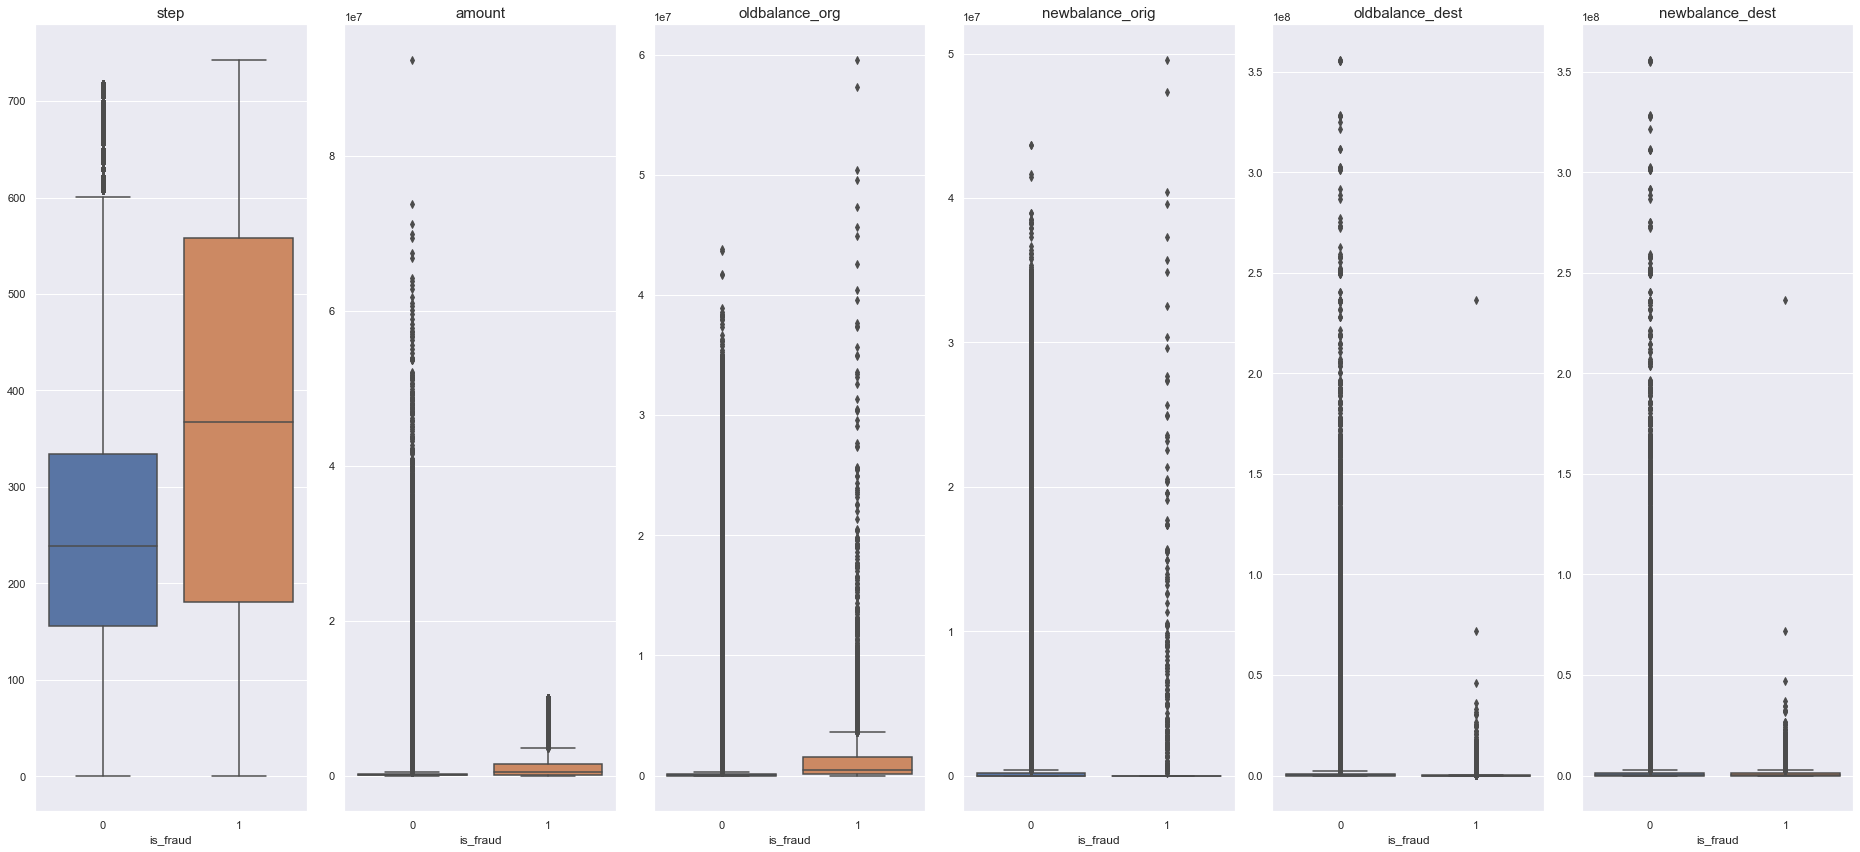

In [15]:


f, axes = plt.subplots(1, 6, figsize = (26, 12))
for var, ax in zip(variables, f.axes):

    b = sns.boxplot(y = var,x='is_fraud', data = aux, ax = ax)
    b.axes.set_title(var,fontsize = 15)
    b.set_ylabel("")

plt.tight_layout()
plt.show()

Zoom:

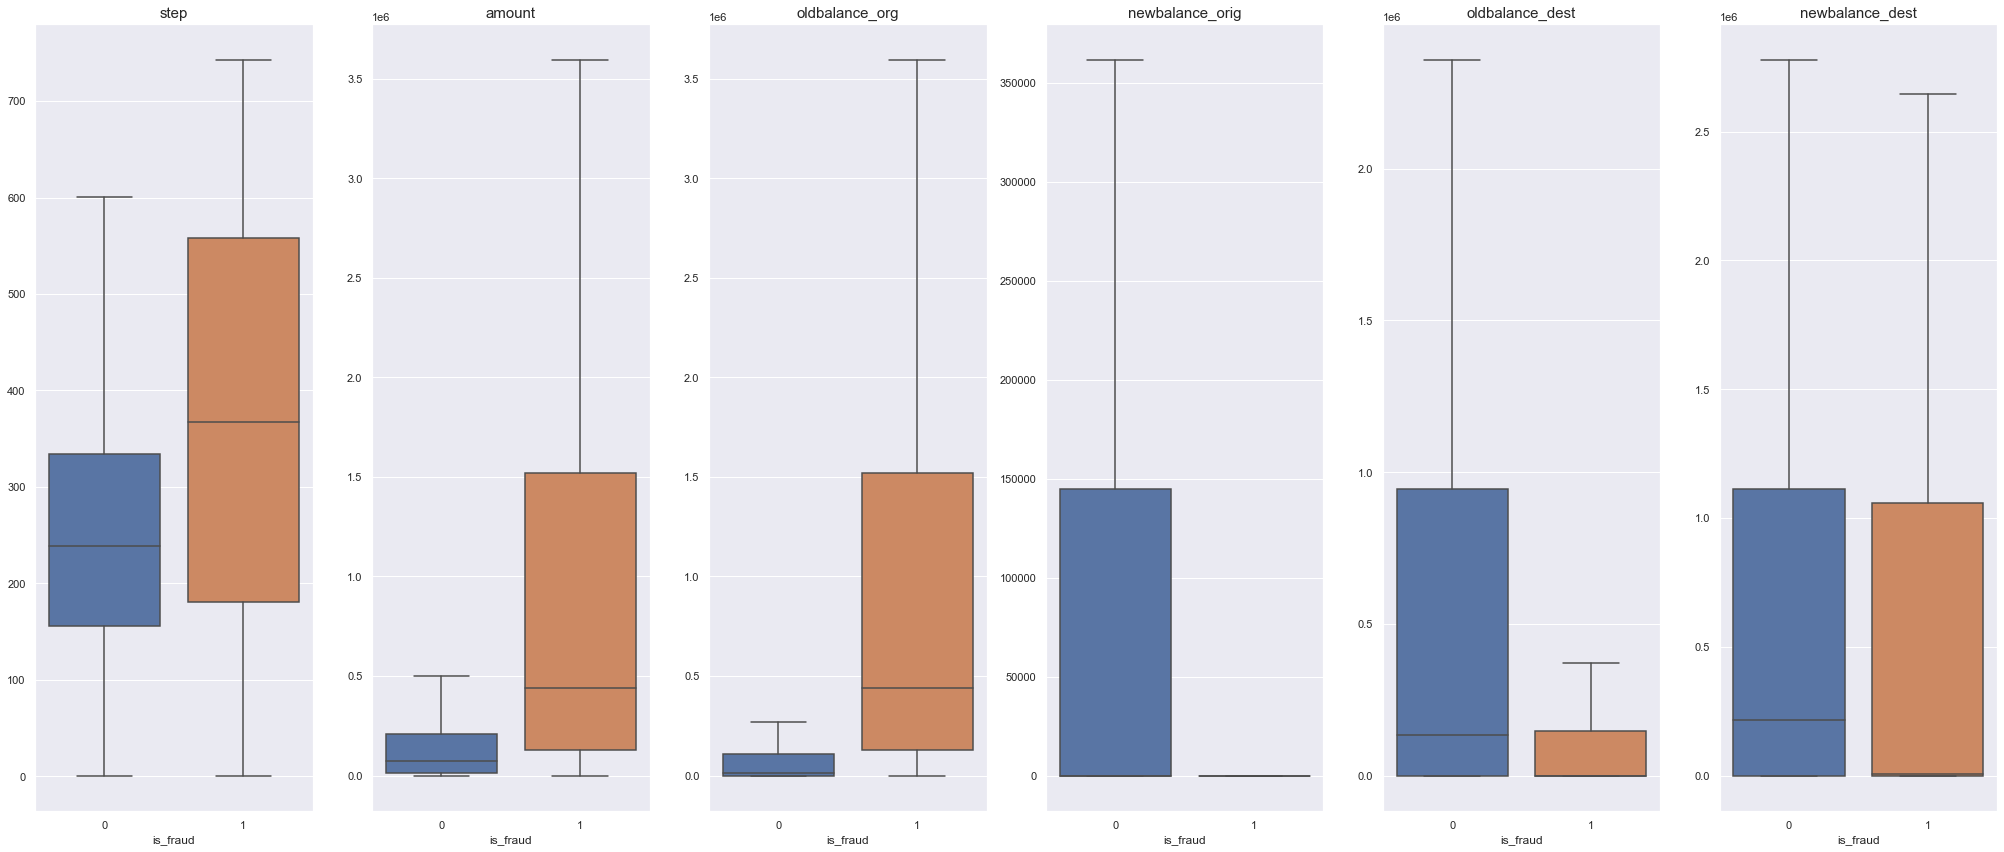

In [16]:
f, axes = plt.subplots(1, 6, figsize = (28, 12))
for var, ax in zip(variables, f.axes):
    

    b = sns.boxplot(y = var,x='is_fraud', data = aux, ax = ax,showfliers = False)
    b.axes.set_title(var,fontsize = 15)
    b.set_ylabel("")

plt.tight_layout()
plt.show()

### 1.6.2 Categorical Attributes 

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type                      5
name_orig           6353307
name_dest           2722362
is_fraud                  2
is_flagged_fraud          2
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_flagged_fraud', ylabel='count'>

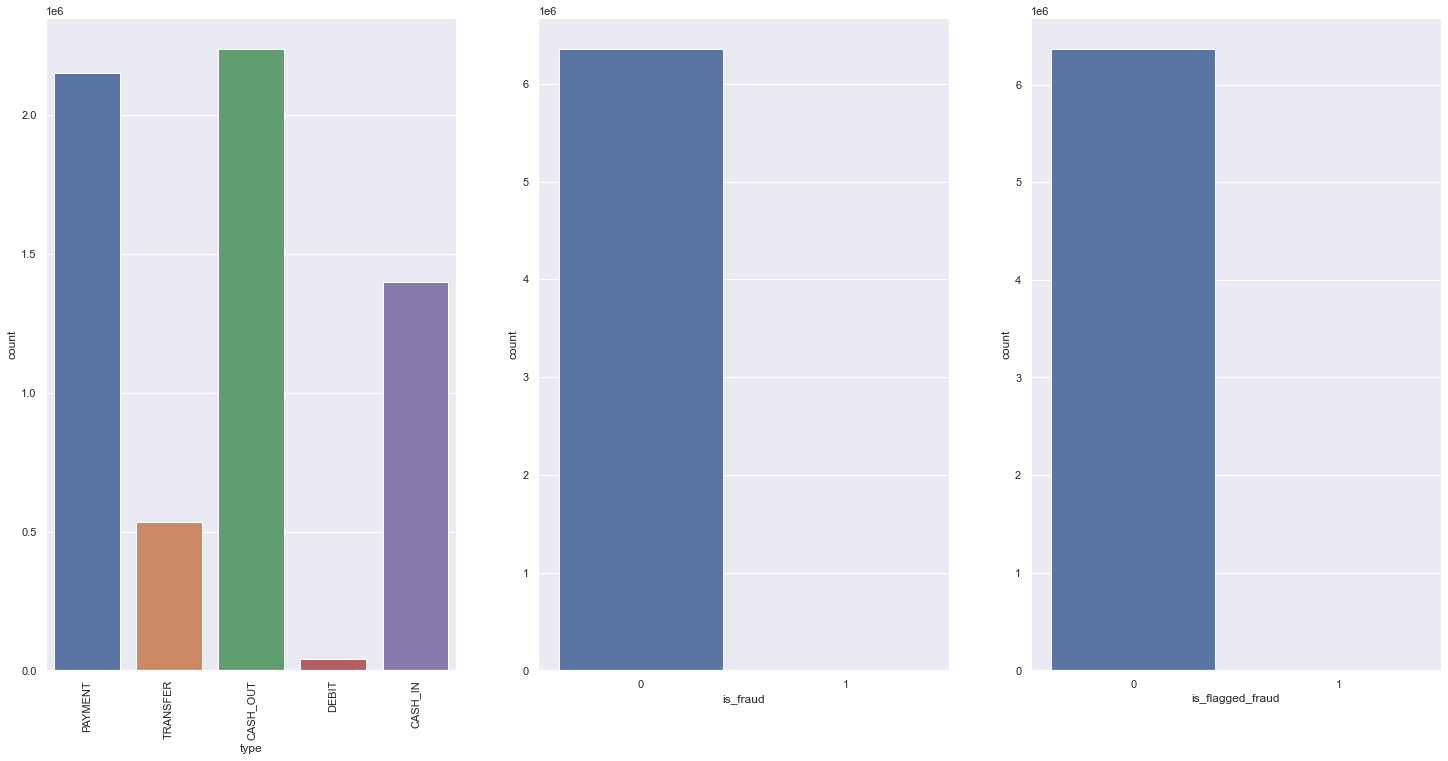

In [18]:
#plt.subplots(figsize = (16, 4))

plt.subplot(1,3,1)
sns.countplot(df1['type'])
plt.xticks(rotation=90)


plt.subplot(1,3,2)
sns.countplot(df1['is_fraud'])

plt.subplot(1,3,3)
sns.countplot(df1['is_flagged_fraud'])

In [19]:
# Check "is_fraud"
print(df1['is_fraud'].value_counts())

#or i in (df1['is_fraud'].value_counts(normalize = True)):
#   print()
    
for idx, val in enumerate(df1['is_fraud'].value_counts(normalize = True)):
    print(f'{idx} : {100*val:.4} %')

0    6354407
1       8213
Name: is_fraud, dtype: int64
0 : 99.87 %
1 : 0.1291 %


In [20]:
# Check "is_flagged_fraud"
print(df1['is_flagged_fraud'].value_counts())

for idx, val in enumerate(df1['is_flagged_fraud'].value_counts(normalize = True)):
    print(f'{idx} : {100*val:.6} %')

0    6362604
1         16
Name: is_flagged_fraud, dtype: int64
0 : 99.9997 %
1 : 0.000251469 %


- It is possible to see that data is highly unbalanced

# 2.0 Feature Engineering

In [21]:
df2 = df1.copy()

## 2.1 Hypothesis mind map

<img src="img/MindMapHypotesis.png">

## 2.2 Hypotheses Creation


### Number of transactions 

**1.** Customers who already had frauds in their transactions are more likely to have fraudulent transactions.

**2.** Sudden changes in a customer's number of transactions per week may indicate a fraudulent transaction

### Flagged fraud

**1.** Transaction that has Fraud flagged is always a fraud

### Transaction type

**1.** Transfer transaction is more likely to be a fraud

### Transaction amount

**1.** The higher the value of the transaction the greater the chance of being fraud.

**2.** Zero-value transactions are more likely to be fraud

### Balance

**1.** Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)

**2.** Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)

**3.** Transactions that differ between the old balance and the new balance are more likely to be fraudulent.

### Clients

**1.** Transactions received by non-merchants are more likely to be a fraud

### Time

**1.** Transactions made outside normal hours are more likely to be fraud.

**2.** Transactions made on the first 15 days of the month are more likely to be a fraud.










## 2.3 Final hypotheses list

The hypotheses were chosen based on the data that have already been obtained and can be used for study. For other hypotheses to be tested, there needs to be a greater collection of data from different areas of the company.

**1.** Transaction that has Fraud flagged is always a fraud

**2.** Transfer transaction is more likely to be a fraud

**3.** The higher the value of the transaction the greater the chance of being fraud.

**4.** Zero-value transactions are more likely to be fraud

**5.** Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)

**6.** Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)

**7.** Transactions that differ between the old balance and the new balance are more likely to be fraudulent.

**8.** Transactions received by non-merchants are more likely to be a fraud

**9.** Transactions made outside normal hours are more likely to be fraud.

**10.** Transactions made on the first 15 days of the month are more likely to be a fraud.

## 2.4 Feature Engineering

In [22]:
df2 = df1.copy()

In [23]:
# step

## outside normal hour  (normal: 7h - 0h, not normal: 0h - 7h)

## hour
df2['hour'] = df2['step'].apply(lambda x: x%24)

df2['outside_normal_hour'] = df2['step'].apply(lambda x: 1 if (0<x<7) else 0 )

## day
df2['day'] = df2['step'].apply(lambda x: int(x/24) + 1)

## week
df2['week'] = df2['day'].apply(lambda x: 1 if (x<=7) else 2 if (x <=14) else 3 if (x <=21) else 4)

# amount
df2['aux_amount'] = df2['type'].apply(lambda x: -1 if x =="CASH_IN" else 1)
df2['amount'] = df2['amount'] * df2['aux_amount']
df2 = df2.drop(columns=['aux_amount'])

df2['amount_is_zero'] = df2['amount'].apply(lambda x: 1 if x == 0 else 0)

#name_orig
df2['client_orig'] = df2['name_orig'].apply(lambda x: 'merchant' if "M" in x else "non-merchant")

#name_dest
df2['client_dest'] = df2['name_dest'].apply(lambda x: "merchant" if "M" in x else "non-merchant")

#difference between old and new balance 
df2['error_balance_orig'] = np.round((df2['newbalance_orig'] + df2['amount'] - df2['oldbalance_org']),3)

aux1 = df2[df2['client_dest']=='non-merchant'] 

df2['error_balance_dest'] = np.round((aux1['newbalance_dest'] - aux1['amount'] - aux1['oldbalance_dest']),3)
df2.error_balance_dest.fillna(0, inplace=True)

In [24]:
df2.sample(5)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,hour,outside_normal_hour,day,week,amount_is_zero,client_orig,client_dest,error_balance_orig,error_balance_dest
2262738,187,CASH_OUT,124326.51,C1148703075,68011.00,0.00,C1636156542,0.00,124326.51,0,0,19,0,8,2,0,non-merchant,non-merchant,56315.51,0.00
2206685,186,DEBIT,1432.04,C446115830,11622.00,10189.96,C1576234609,38514.41,39946.46,0,0,18,0,8,2,0,non-merchant,non-merchant,0.00,0.01
1531110,154,PAYMENT,16848.97,C1685328718,131981.81,115132.84,M1402781348,0.00,0.00,0,0,10,0,7,1,0,non-merchant,merchant,0.00,0.00
411966,18,PAYMENT,12307.14,C779598640,40371.00,28063.86,M1367463900,0.00,0.00,0,0,18,0,1,1,0,non-merchant,merchant,0.00,0.00
1257061,134,CASH_OUT,343398.84,C18960536,0.00,0.00,C885524491,1296069.41,1639468.25,0,0,14,0,6,1,0,non-merchant,non-merchant,343398.84,0.00


# 3.0 Variable filtering

In [25]:
df3 = df2.copy()

## 3.1 Line filtering

We have a very large number of outliers, so in the data preparation stage we will separate it into two paths, one with the presence of all outliers, and another path that will be with cleaning part of the outliers. Different models will be used for each one.

## 3.2 Column selection

# 4.0 Exploratory data analysis

In [26]:
df4 = df3.copy() 

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_fraud', ylabel='count'>

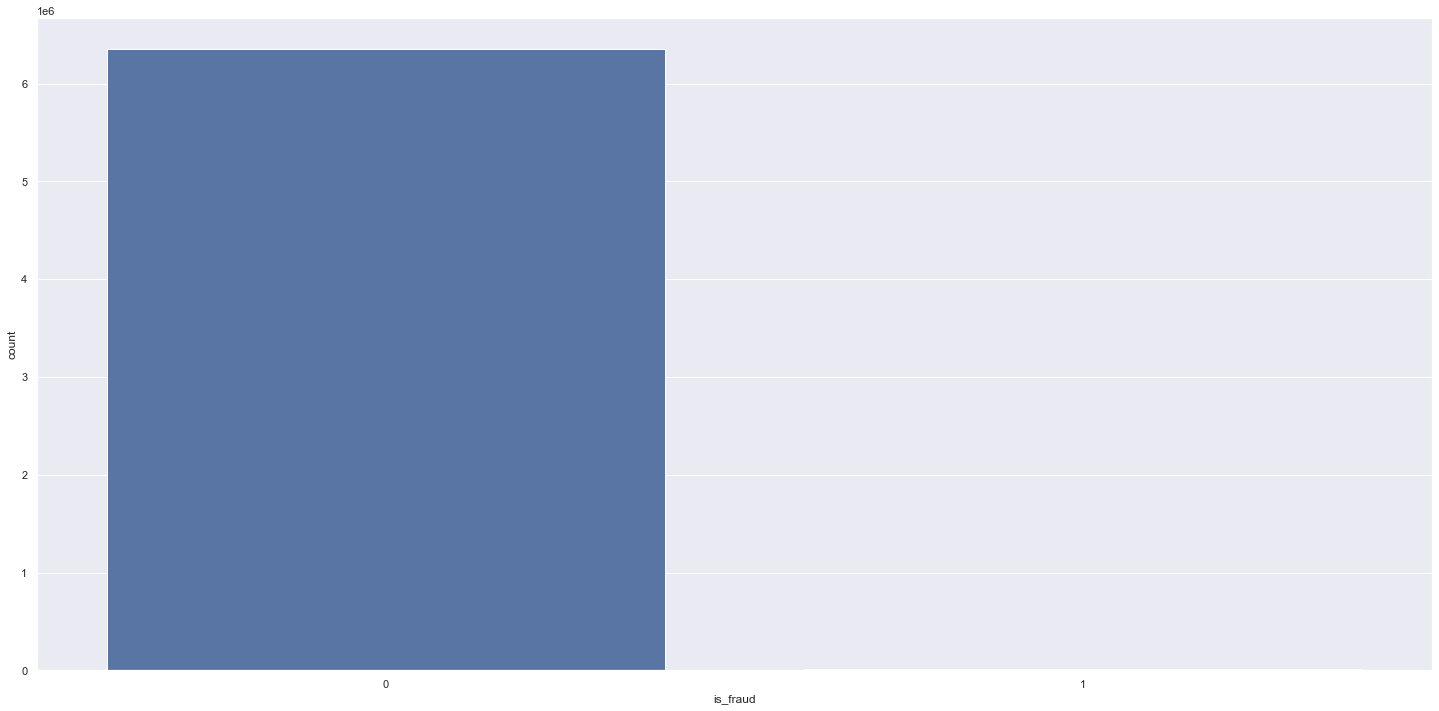

In [27]:
sns.countplot(df4['is_fraud'])

- One more time, we can see that the data is very unbalanced

### 4.1.2 Numerical Variable

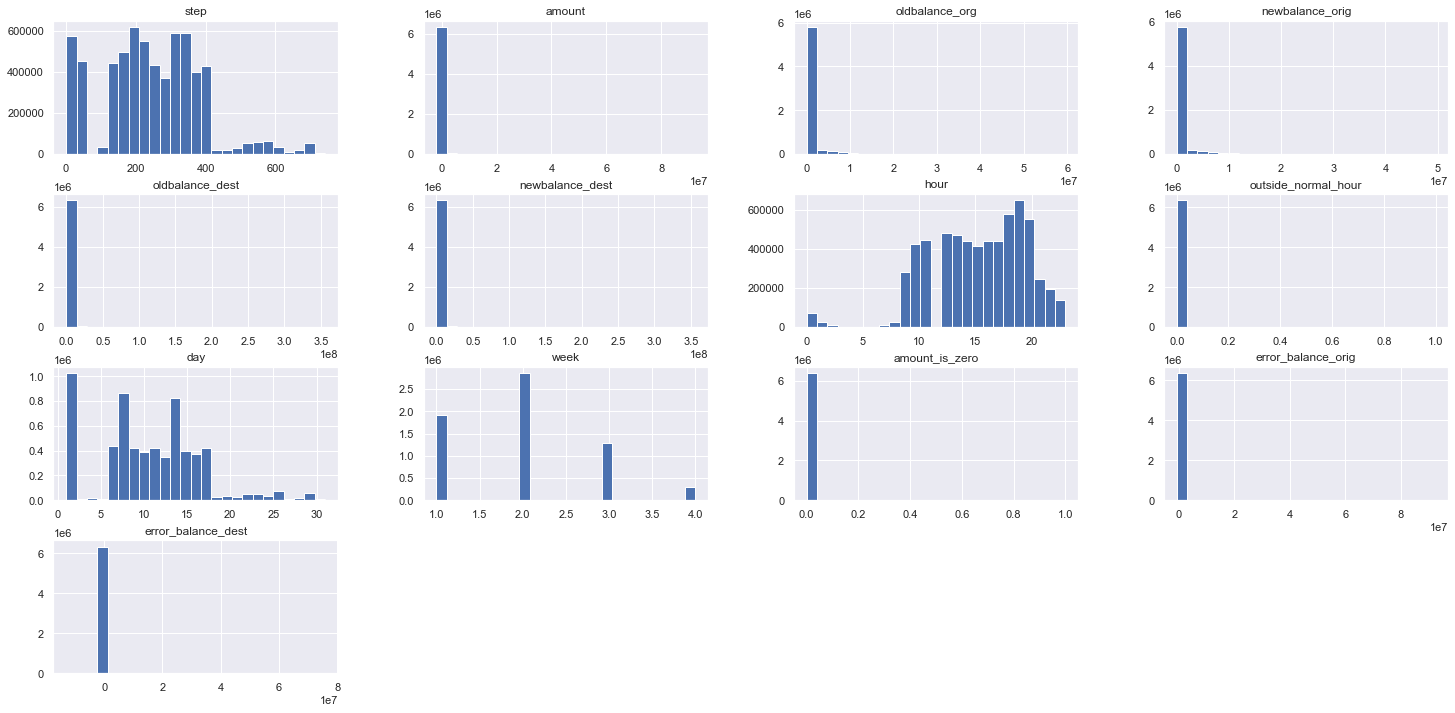

In [28]:
num_attributes = df4.select_dtypes(include = ['int64','float64'])
num_attributes.hist(bins = 25);

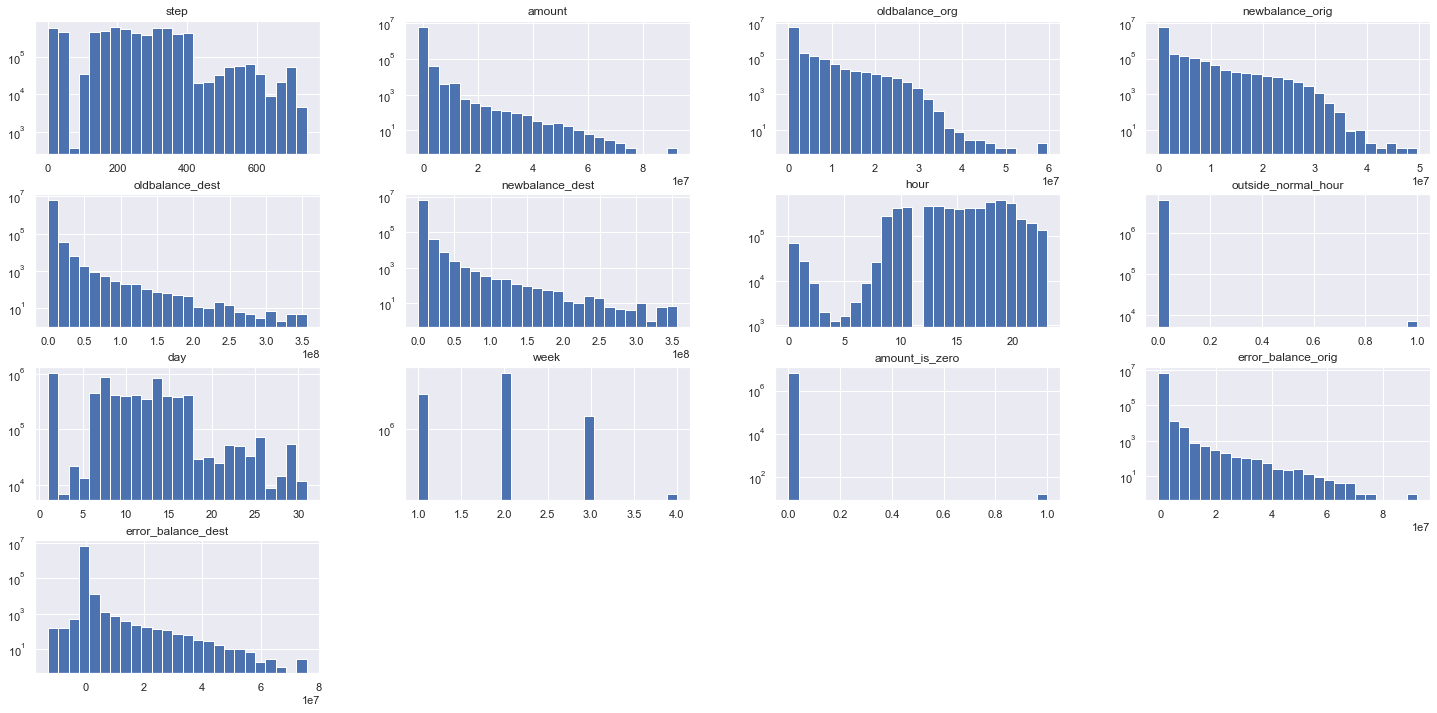

In [29]:
num_attributes = df4.select_dtypes(include = ['int64','float64'])
num_attributes.hist(bins = 25, log=True);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated 

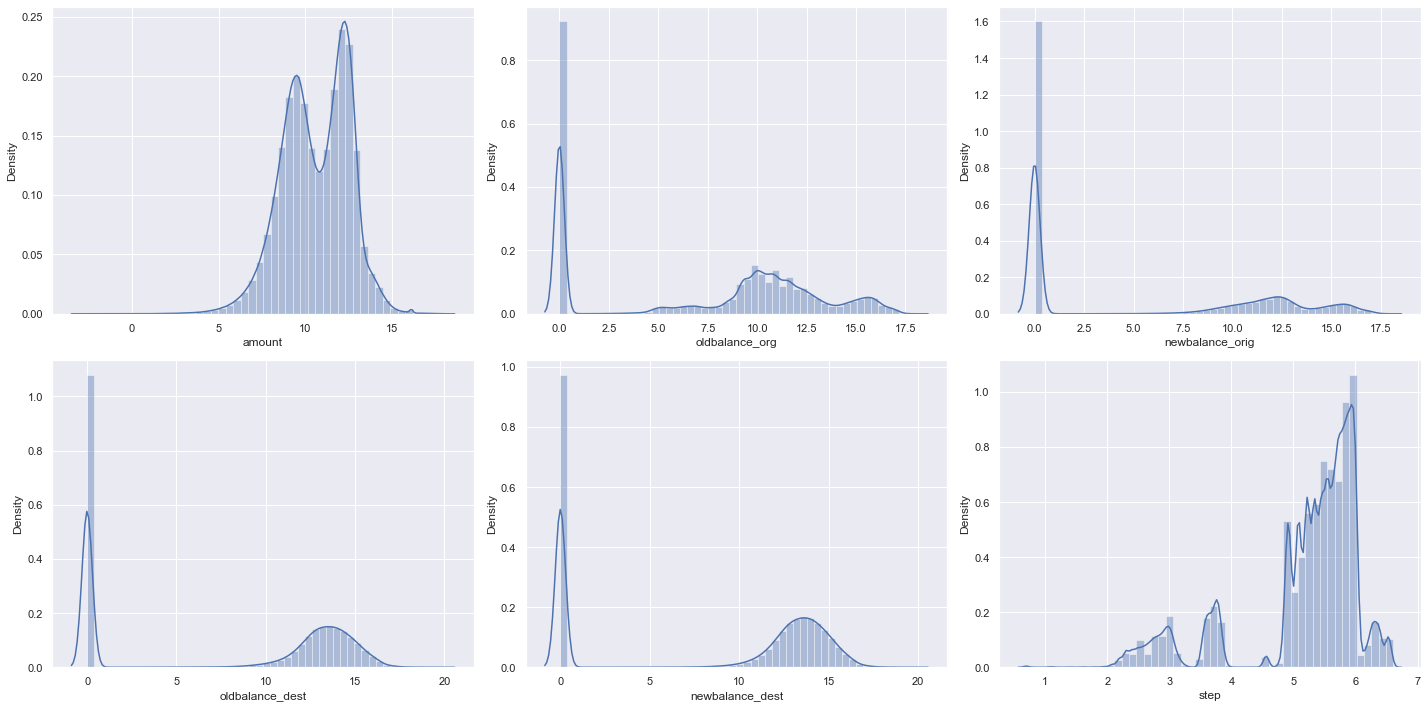

In [30]:
vari = ['amount', 'oldbalance_org','newbalance_orig','oldbalance_dest','newbalance_dest','step']

f, axes = plt.subplots(2, 3, figsize = (20, 10))
for var, ax in zip(vari, f.axes):
    b = sns.distplot(np.log1p(num_attributes[var]), ax = ax)

plt.tight_layout()
plt.show()

### 4.1.3 Categorical Variable

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='client_dest', ylabel='count'>

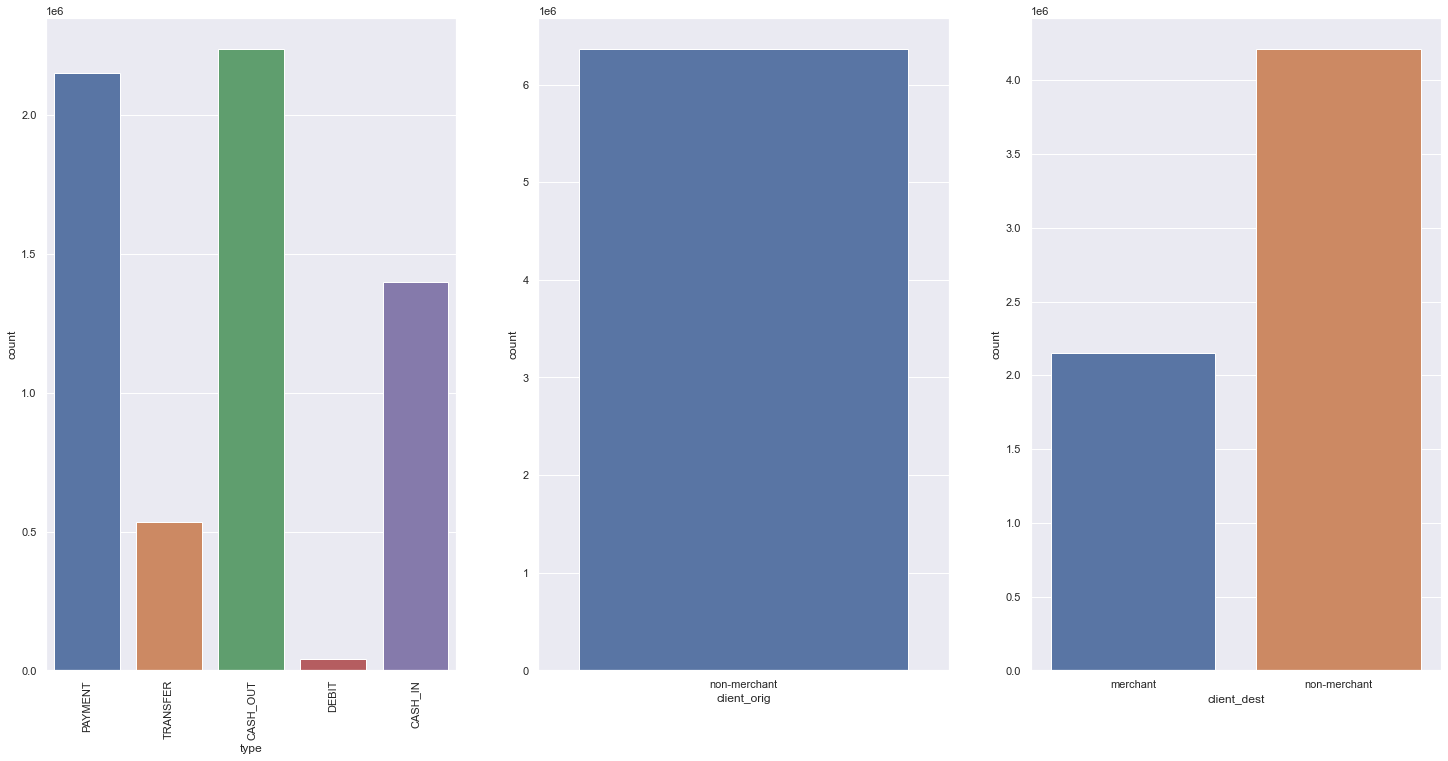

In [31]:
plt.subplot(1,3,1)
sns.countplot(df4['type'])
plt.xticks(rotation=90)


plt.subplot(1,3,2)
sns.countplot(df4['client_orig'])

plt.subplot(1,3,3)
sns.countplot(df4['client_dest'])

Key points:

- The most frequently types of transactions, in ascending order: Debit, Transfer, Cash-in, Payment and Cash-out. 
- Just non-merchant clients do transactions. Merchants only receive.


## 4.2 Bivariate analysis

### **H1** Transaction that has Fraud flagged is always a fraud
**true**


<AxesSubplot:xlabel='is_fraud', ylabel='count'>

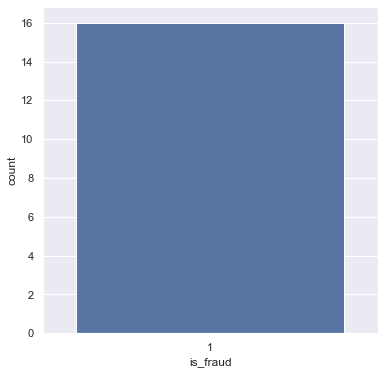

In [32]:
plt.figure(figsize=(6,6))

a=df4[df4['is_flagged_fraud'] == 1]
b=a[['is_flagged_fraud','is_fraud']]
sns.countplot(x='is_fraud',data=b)

In [33]:
a = df4[['is_flagged_fraud','is_fraud']].groupby(['is_fraud']).sum().reset_index()
a

,is_fraud,is_flagged_fraud
0,0,0
1,1,16


### **H2** Transfer transaction is more likely to be a fraud
**false** Only transfer and cash-out transactions are fraudulent. cash-out has 4116 frauds, slightly higher than transfer (4097)

Text(0.5, 1.0, 'Fraud = true')

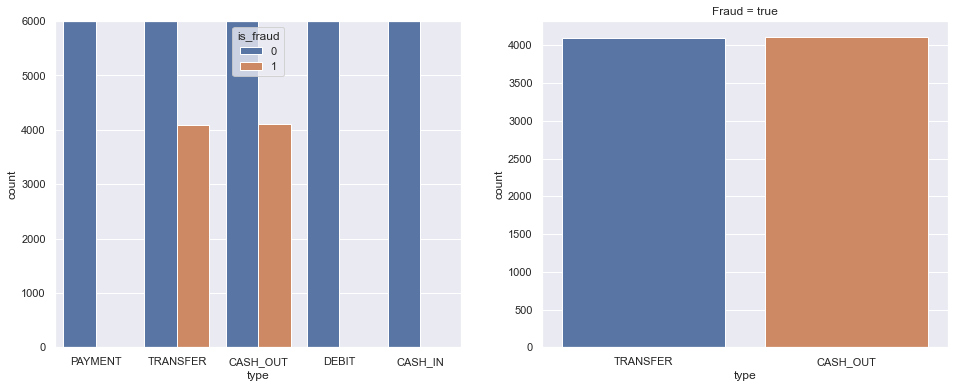

In [34]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='type', data = df4, hue='is_fraud')
ax.set_ylim([0,6000])

plt.subplot(1,2,2)
aux = df4[df4['is_fraud']==1]
ax = sns.countplot(x='type', data = aux)
plt.title("Fraud = true")

In [35]:
aux.type.value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

### **H3** The higher the value of the transaction the greater the chance of being fraud.
**true#** The hypothesis is true, but only in amounts below 10,000,000. Above that amount there aren't cases of fraud.


In [36]:
aux1 = pd.DataFrame()
aux_fraud = pd.DataFrame()
aux_fraud['is_fraud'] = df4['is_fraud']
aux_fraud['is_fraud'] = aux_fraud.is_fraud.astype('int64')*100

bi = list(np.arange(0,100000000,100000))
aux1['amount_binned'] = pd.cut(x = df4['amount'], bins=bi)

aux2 = pd.concat([aux1,aux_fraud],axis=1)
aux3 = aux2.groupby('amount_binned').mean().reset_index()
aux4 = aux3[aux3['is_fraud']>0.0]

In [37]:
aux5 = df4[df4['is_fraud']==1]
aux6 = aux5.sort_values(by=['amount'], ascending=False)
aux6.head(5)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,hour,outside_normal_hour,day,week,amount_is_zero,client_orig,client_dest,error_balance_orig,error_balance_dest
3760283,279,CASH_OUT,10000000.0,C1214015158,10000000.00,0.00,C2110157840,0.00,10000000.00,1,0,15,0,12,2,0,non-merchant,non-merchant,0.0,0.0
5987587,409,CASH_OUT,10000000.0,C97242201,10000000.00,0.00,C786701128,8496.86,10008496.86,1,0,1,0,18,3,0,non-merchant,non-merchant,0.0,-0.0
1707592,160,CASH_OUT,10000000.0,C525906402,10000000.00,0.00,C43869769,2145275.47,12145275.47,1,0,16,0,7,1,0,non-merchant,non-merchant,0.0,0.0
1707591,160,TRANSFER,10000000.0,C752627210,27670038.08,17670038.08,C1853789265,0.00,0.00,1,0,16,0,7,1,0,non-merchant,non-merchant,0.0,-10000000.0
1707590,160,CASH_OUT,10000000.0,C2068007279,10000000.00,0.00,C836488544,158643.25,10158643.25,1,0,16,0,7,1,0,non-merchant,non-merchant,0.0,0.0


the largest amount that is fraud is 10 million

Text(0, 0.5, 'Is Fraud in percentage')

<Figure size 1728x720 with 0 Axes>

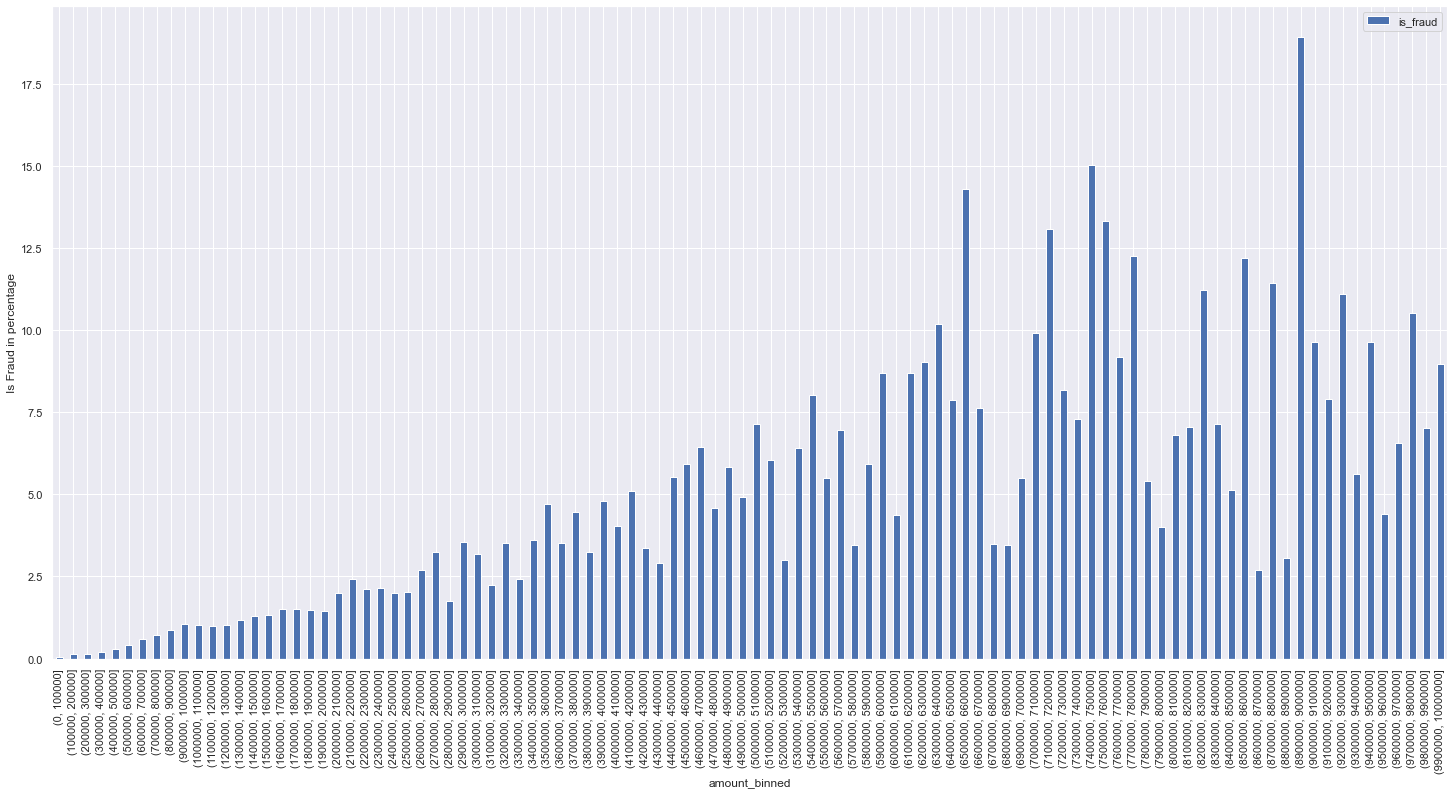

In [38]:
plt.figure(figsize=(24,10))
ax = aux4.plot.bar(x='amount_binned', y='is_fraud')
ax.set_ylabel("Is Fraud in percentage")

<AxesSubplot:>

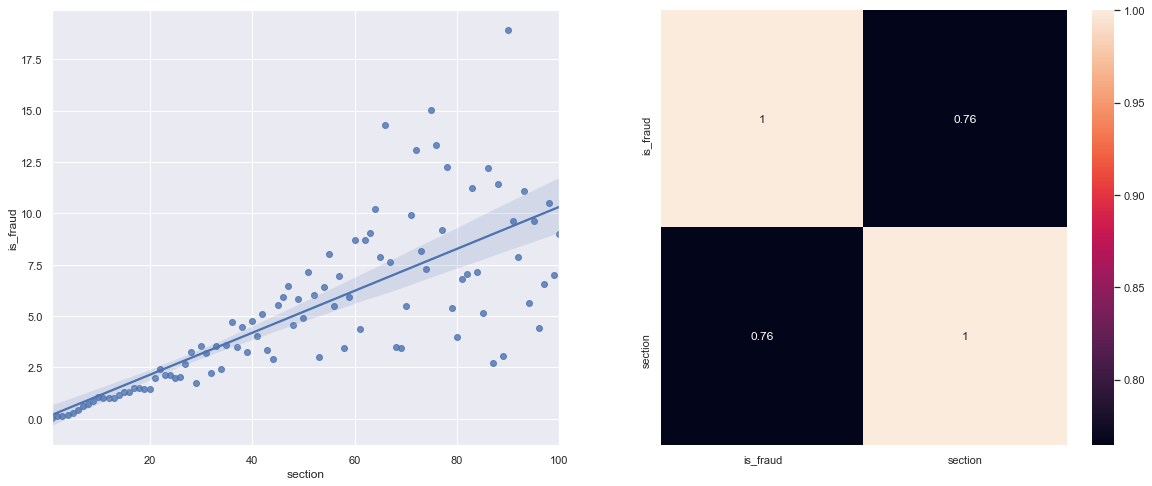

In [39]:
plt.figure(figsize=(20,8))

aux_plot = aux4.drop(columns=["amount_binned"])
aux_plot['section'] = range(1,len(aux4)+1)

plt.subplot(1,2,1)
sns.regplot(x='section', y='is_fraud', data=aux_plot)


plt.subplot(1,2,2)
sns.heatmap(aux_plot.corr(method='pearson'), annot=True)

### **H4.** Zero-value transactions are more likely to be fraud
**true** All zero value transactions are fraud



In [41]:
aux = df4[df4['amount']==0]

print('Number of zero-value transaction:', aux.shape[0] )
print('Number of frauds:', aux.is_fraud.value_counts())


Number of zero-value transaction: 16
Number of frauds: 1    16
Name: is_fraud, dtype: int64


### **H5.** Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)
**False#** There are some frauds in this type of transaction, but they are only 0.00195%.


In [42]:
aux_h5 = df4[df4['oldbalance_org']==0]

print('Transactions whose initial balance is zero:', aux_h5.shape[0] )
print('Number of frauds:')
print(aux_h5.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((41/2102449)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose initial balance is zero: 2102449
Number of frauds:
0    2102408
1         41
Name: is_fraud, dtype: int64
percentage of frauds: 0.00195 %


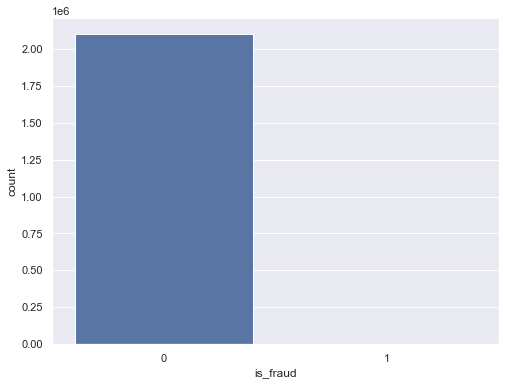

In [43]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='is_fraud', data=aux_h5)

### **H6.** Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)
**true** Transactions with final balance = 0, have 0,22% of frauds while the others have 0,006%

In [44]:
# FINAL BALANCE = 0 
aux_h6 = df4[df4['newbalance_orig']==0]

print('Transactions whose final balance is zero:', aux_h6.shape[0] )
print('Number of frauds:')
print(aux_h6.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((8053/3609566)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose final balance is zero: 3609566
Number of frauds:
0    3601513
1       8053
Name: is_fraud, dtype: int64
percentage of frauds: 0.22310 %


In [45]:
# FINAL BALANCE != 0
aux_h62 = df4[df4['newbalance_orig'] !=0]

print('Transactions whose final balance is zero:', aux_h62.shape[0] )
print('Number of frauds:')
print(aux_h62.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((160/2753054)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose final balance is zero: 2753054
Number of frauds:
0    2752894
1        160
Name: is_fraud, dtype: int64
percentage of frauds: 0.00581 %


### **H7.** Transactions that differ between the old balance and the new balance are more likely to be fraudulent.
**false** Transactions that have a difference actually have a lower percentage of fraud

In [46]:
# DON'T HAVE DIFFERENCE
aux_h7 = df4[(df4['error_balance_orig'] ==0) | (df4['error_balance_dest']==0)]

print('Transactions whose final balance is zero:', aux_h7.shape[0] )
print('Number of frauds:')
print(aux_h7.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((8185/5542790)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose final balance is zero: 5542790
Number of frauds:
0    5534605
1       8185
Name: is_fraud, dtype: int64
percentage of frauds: 0.14767 %


In [47]:
# HAVE DIFFERENCE
aux_h7 = df4[(df4['error_balance_orig'] !=0) | (df4['error_balance_dest']!=0)]

print('Transactions whose final balance is zero:', aux_h7.shape[0] )
print('Number of frauds:')
print(aux_h7.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((4897/4552968)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose final balance is zero: 4557865
Number of frauds:
0    4552968
1       4897
Name: is_fraud, dtype: int64
percentage of frauds: 0.10756 %


### **H8.** Transactions received by non-merchants are more likely to be a fraud

**true** 0.19541% of transactions for non-merchant are fraud, while for merchant there is no fraud


In [48]:
aux_h8 = df4[df4['client_dest']=='non-merchant']

print('Transactions :', aux_h8.shape[0] )
print('Number of frauds:')
print(aux_h8.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((8213/4202912)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))



Transactions : 4211125
Number of frauds:
0    4202912
1       8213
Name: is_fraud, dtype: int64
percentage of frauds: 0.19541 %


In [49]:
aux_h8 = df4[df4['client_dest']=='merchant']

print('Transactions :', aux_h8.shape[0] )
print('Number of frauds:')
print(aux_h8.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % (0), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions : 2151495
Number of frauds:
0    2151495
Name: is_fraud, dtype: int64
percentage of frauds: 0.00000 %


### **H9.** Transactions made outside normal hours are more likely to be fraud.
**true** 


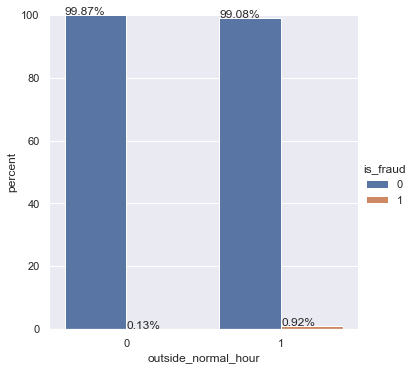

In [50]:
x,y = 'outside_normal_hour', 'is_fraud'

df = df4.groupby(x)[y].value_counts(normalize=True)
df = df.mul(100)
df = df.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [51]:
aux_h9 = df4[df4['outside_normal_hour']==1]

print('Transactions :', aux_h9.shape[0] )
print('Number of frauds:')
print(aux_h9.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((66/7164)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions : 7164
Number of frauds:
0    7098
1      66
Name: is_fraud, dtype: int64
percentage of frauds: 0.92127 %


In [52]:
aux_h9 = df4[df4['outside_normal_hour']!=1]

print('Transactions:', aux_h9.shape[0] )
print('Number of frauds:')
print(aux_h9.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((8147/6355456)*100), '%')

Transactions: 6355456
Number of frauds:
0    6347309
1       8147
Name: is_fraud, dtype: int64
percentage of frauds: 0.12819 %


### **H10.** Transactions made on the first 15 days of the month are more likely to be a fraud.
**false** The amount of fraud in the second half of the month is lower, but the percentage is higher, due to the number of transactions that decreases over the month


<AxesSubplot:>

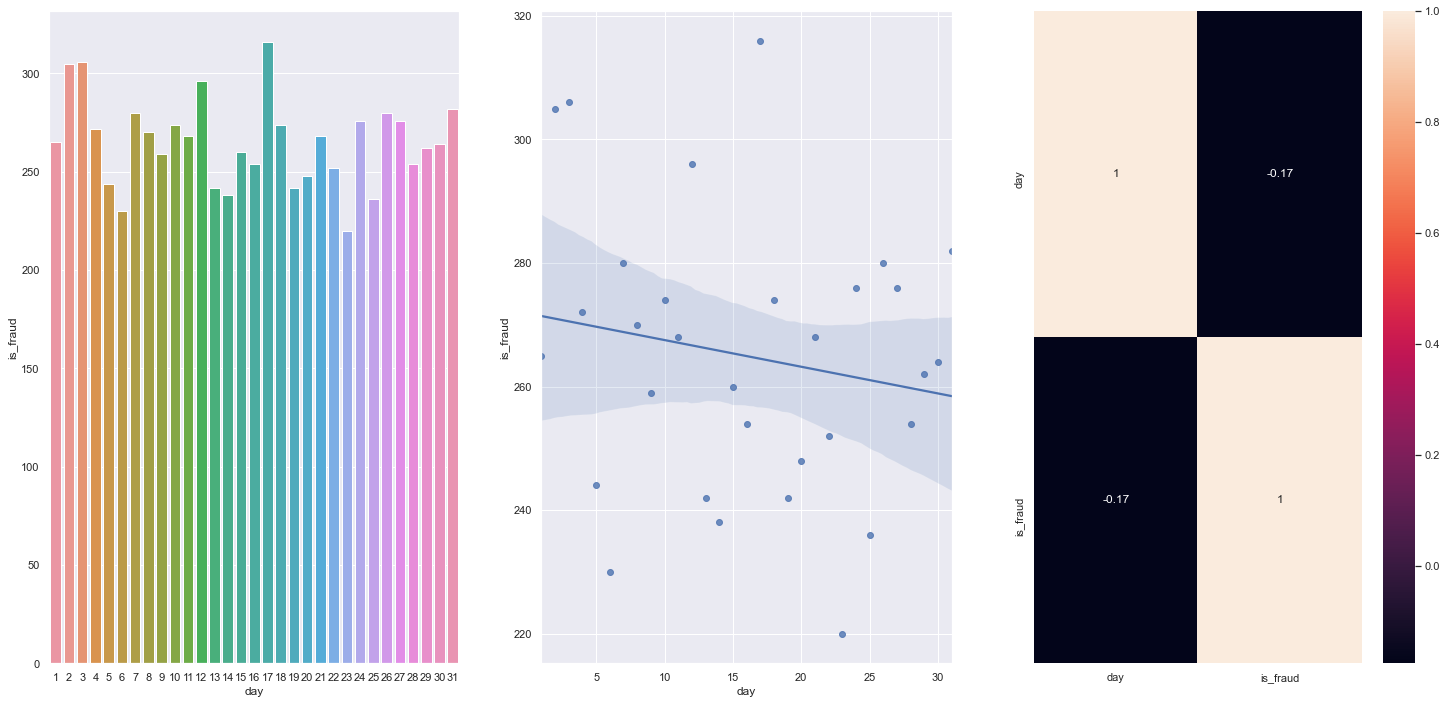

In [53]:
aux1 = df4[['is_fraud','day']].groupby(['day']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day', y='is_fraud', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day', y='is_fraud', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

In [54]:
#FIRST 15 DAYS

aux_h10 = df4[df4['day']<=15]

print('Transactions:', aux_h10.shape[0] )
print('Number of frauds:')
print(aux_h10.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((4009/5178540)*100), '%')

Transactions: 5182549
Number of frauds:
0    5178540
1       4009
Name: is_fraud, dtype: int64
percentage of frauds: 0.07742 %


In [55]:
#LAST 16 DAYS

aux_h10 = df4[df4['day']>=16]

print('Transactions:', aux_h10.shape[0] )
print('Number of frauds:')
print(aux_h10.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((4204/1175867)*100), '%')

Transactions: 1180071
Number of frauds:
0    1175867
1       4204
Name: is_fraud, dtype: int64
percentage of frauds: 0.35752 %


### 4.2.1 Summary of hypotheses

In [56]:
tab = [['hypotheses', 'conclusion', 'relevance',''],
        ['H1', 'True', 'High','Transaction that has Fraud flagged is always a fraud'],
        ['H2', 'False', 'High','Transfer transaction is more likely to be a fraud'],
        ['H3', 'True', 'Medium','The higher the value of the transaction the greater the chance of being fraud.'],
        ['H4', 'True', 'High','Zero-value transactions are more likely to be fraud'],
        ['H5', 'False', 'Medium','Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)'],
        ['H6', 'True', 'High','Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)'],
        ['H7', 'False', 'Low','Transactions that differ between the old balance and the new balance are more likely to be fraudulent.'],
        ['H8', 'True', 'Low','Transactions made and received by non-merchants are more likely to be a fraud'],
        ['H9', 'True', 'Low','Transactions made outside normal hours are more likely to be fraud.'],
        ['H10', 'False', 'Low','Transactions made on the first 15 days of the month are more likely to be a fraud.'],
     ]

print (tabulate (tab, headers = 'firstrow'))

hypotheses    conclusion    relevance
------------  ------------  -----------  --------------------------------------------------------------------------------------------------------------
H1            True          High         Transaction that has Fraud flagged is always a fraud
H2            False         High         Transfer transaction is more likely to be a fraud
H3            True          Medium       The higher the value of the transaction the greater the chance of being fraud.
H4            True          High         Zero-value transactions are more likely to be fraud
H5            False         Medium       Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)
H6            True          High         Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)
H7            False         Low          Transactions that differ between the old balance and the new balance are more 

## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

In [64]:
aux = num_attributes.copy()
aux['is_fraud'] = df4['is_fraud']
aux['is_flagged_fraud'] = df4['is_flagged_fraud']

aux['is_fraud'] = aux.is_fraud.astype('int64')
aux['is_flagged_fraud'] = aux.is_flagged_fraud.astype('int64')


<AxesSubplot:>

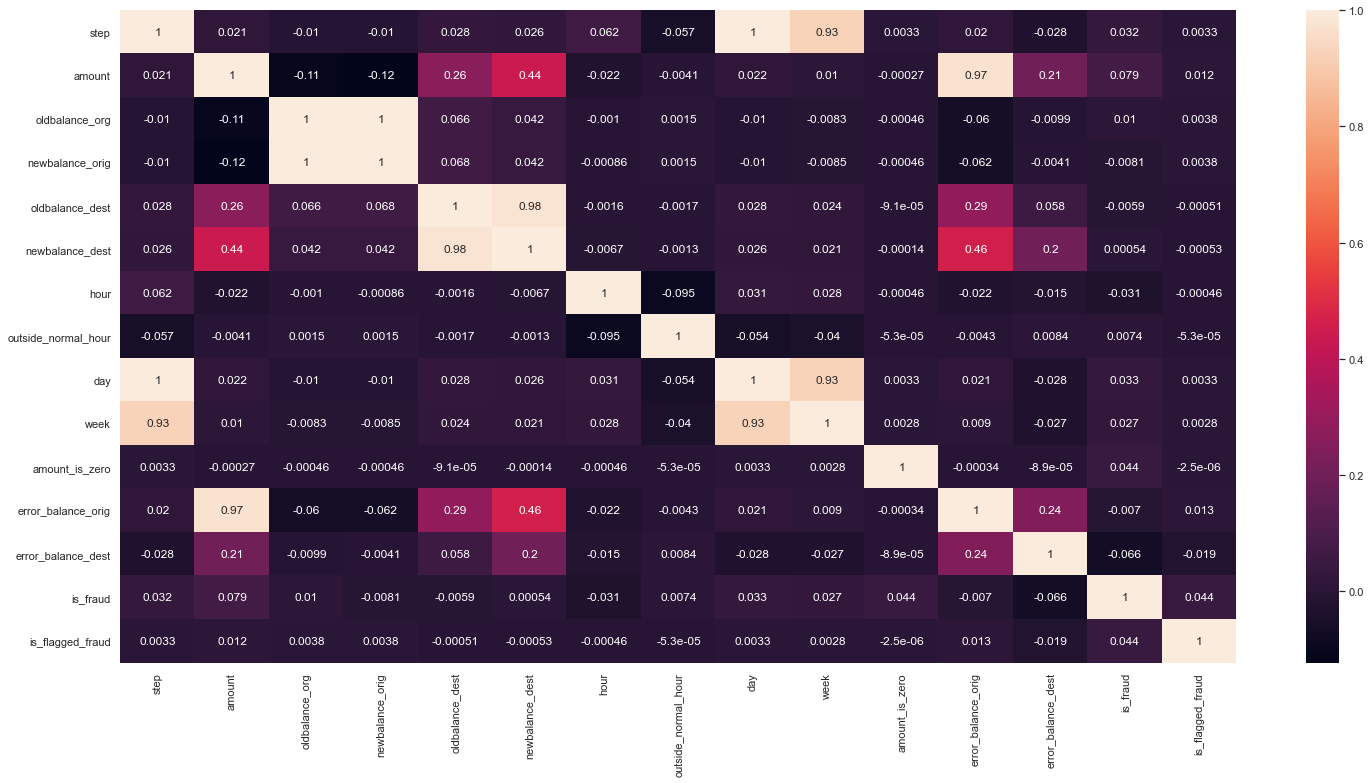

In [63]:
correlation = aux.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

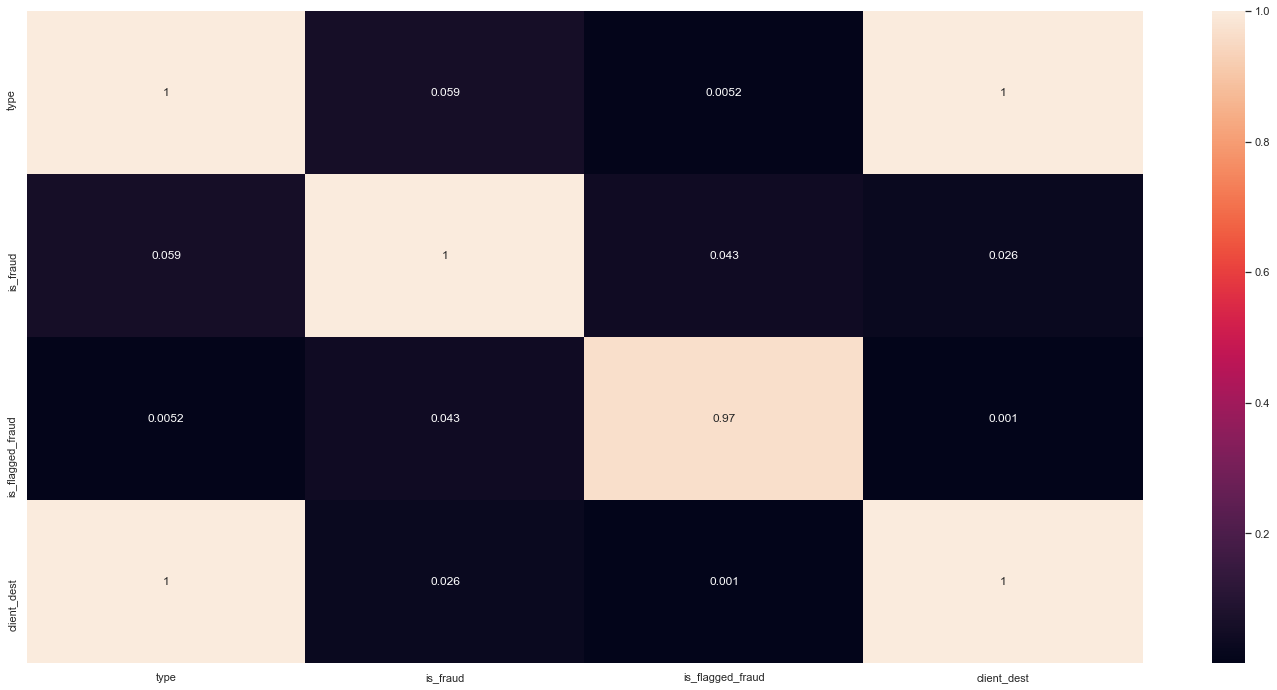

In [71]:
a = df4.select_dtypes(include = 'object')

a1 = cramer_v(a['type'], a['type'])
a2 = cramer_v(a['type'], a['is_fraud'])
a3 = cramer_v(a['type'], a['is_flagged_fraud'])
a4 = cramer_v(a['type'], a['client_dest'])

a5 = cramer_v(a['is_fraud'], a['type'])
a6 = cramer_v(a['is_fraud'], a['is_fraud'])
a7 = cramer_v(a['is_fraud'], a['is_flagged_fraud'])
a8 = cramer_v(a['is_fraud'], a['client_dest'])

a9 = cramer_v(a['is_flagged_fraud'], a['type'])
a10 = cramer_v(a['is_flagged_fraud'], a['is_fraud'])
a11 = cramer_v(a['is_flagged_fraud'], a['is_flagged_fraud'])
a12 = cramer_v(a['is_flagged_fraud'], a['client_dest'])

a13 = cramer_v(a['client_dest'], a['type'])
a14 = cramer_v(a['client_dest'], a['is_fraud'])
a15 = cramer_v(a['client_dest'], a['is_flagged_fraud'])
a16 = cramer_v(a['client_dest'], a['client_dest'])

d = pd.DataFrame({'type':[a1,a2,a3,a4],
              'is_fraud':[a5,a6,a7,a8],
              'is_flagged_fraud':[a9,a10,a11,a12],
              'client_dest':[a13,a14,a15,a16]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True);

- Client_orig was not included because it only has one type
- It is interesting to see that the type and the clien_dest have a very strong correlation

# 5.0 Data Preparation